## 참고한 사이트
https://gist.github.com/joelouismarino/a2ede9ab3928f999575423b9887abd14

https://github.com/fchollet/deep-learning-models/pull/59/commits/a38a965112e2239a2f2a1de300cc48388b0d8db6

https://gist.github.com/giuseppebonaccorso/e77e505fc7b61983f7b42dc1250f31c8

In [1]:
from keras.models import Model
from keras import layers
from keras.layers import Input, Dense,Conv2D, Activation, BatchNormalization
from keras.layers import MaxPooling2D, AveragePooling2D, Dropout, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

C:\Users\JHLee\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## GOOGLENET 전반적인 코드 설명

**크게 4가지의 함수를 구현한다. **
1. Batch Normalization이 포함된 Convolution Layer 함수
2. 1X1, 3x3, 5x5, max pooling 이 네가지가 포함된 Inception 함수
3. Auxiliary classifier 함수 
3. 전체적인 GoogleNet 함수 


## convLayer 함수 구현
Batch Normalization이 활성화 단계 이전에 실행되어야 하기 때문에 이를 적용한 convolution layer 함수를 구현하였다.

In [2]:
def convLayer(x,filters,num_row,num_col,padding='same',strides=(1, 1),
              normalizer=True,
              activation='relu'):
    
    #처음에 image data 형식을 확인하여 channels_first라면 ~~~~ (여기 추가하자)
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
   
    #convolution filter 
    x = Conv2D(filters, (num_row, num_col),strides=strides, 
               padding=padding,use_bias=False)(x)
    
    #normalizer가 True라면 batch normalization 실행 
    if normalizer:
        x = BatchNormalization(axis=bn_axis, scale=False)(x)
    
    #activation 실행, 
    #Conv2D에 포함시키지 않은 이유는 BN은 활성화 함수 전에 실행되야 하기 때문
    if activation:
        x = Activation(activation)(x)
    
    return x

## Inception 함수 구현 
inception은 1X1, 3X3,5X5, Maxpooling 4가지 필터를 사용하여 마지막에 concat하는 구조이다. 
specs에 각 크기의 filter의 개수를 입력한다. 

즉, ((64,), (96,128), (16,32), (32,))이렇게 입력한다는 것은 1x1을 64개, 1x1을 이용해 96으로 차원을 축소한 다음 3x3를 이용하여 128개로, 16개로 차원 축소한 다음 5x5를 이용해 32개로, maxpooling하고 난 후 차원을 32로 축소한다는 의미이다. 

In [3]:
def Inception(x, specs, channel_axis):
    (br0, br1, br2, br3) = specs
    
    branch_0 = convLayer(x, br0[0], 1, 1)
    branch_1 = convLayer(x, br1[0], 1, 1)
    branch_1 = convLayer(branch_1, br1[1], 3, 3)
    branch_2 = convLayer(x, br2[0], 1, 1)
    branch_2 = convLayer(branch_2, br2[1], 3, 3)
    branch_3 = MaxPooling2D( (3, 3), strides=(1, 1), padding='same')(x)  
    branch_3 = convLayer(branch_3, br3[0], 1, 1)
    
    x = layers.concatenate([branch_0, branch_1, branch_2, branch_3],axis=channel_axis)
    return x

## Auxiliary Classifier 함수 구현

vanishing gradient 문제를 해결하기 위해서 googlenet에서는 두개의 auxiliary classifier가 존재한다.
이 구조는 5x5/3 stride averagePooling 후 convolution filter를 거친 후 1차원으로 만들어 softmax를 이용하여 loss를 구한다. 
convolution filter가 128인 이유는 논문에 기재되어있지 않고 다른 사람의 코드를 참고하였는데 아직 정확한 이유는 모르겟다,,.. 
대신 dense함수에서 1024,1000개는 googlenet에서 최종loss를 구할때의 개수랑 동일하게 한 것이다.

* 나중에 이 loss 값을 최종 output 산출시 같이 산출하게 하였는데 정확하게 이걸 어떻게 weight에 반영하는지는 잘 모르겟다,, 알아서 반영이 되는걸까? *다시생각해보기

In [4]:
def Aux(x, activation = 'relu') :
    x = AveragePooling2D(pool_size=(5,5),strides=(3,3))(x)   
    x = ConvLayer(x, 128,1,1)
    
    x = Flatten()(x)
    x = Dense(1024, activation= activation)(x)

    x = Dropout(0.7)(x)    
    x = Dense(1000)(x)
    loss = Activation('softmax')(x)
    
    return loss

## 전체적인 googlenet 구조 

*imageNet 기준으로 default input image 크기는 224x224이다.
입력 변수로는 크게 3가지가 있다. weights_path와 input_shape, classes이다.*

weights_path는 None이면 random으로 가중치를 초기화시키겠다는 것이고 imagenet은 ImageNet에 pre-training한 가중치를 사용하겠다는 의미이다.

ImageNet이 워낙 유명한 data이기 때문에 사람들이 적절한 초기 가중치를 몇몇 모델에서 사용할 수 있도록 만들었음 

input_shape는 (224,224,3)이 default 값이고 139보다 작지 않은 width, height를 가진 다른 input data라면 (150,150,3)처럼 입력해주면 된다. 

마지막으로 classes는 1000개로 imageNet에 적합하도록 만든 것이다. 최종 classes가 1000이 아니라면 다른 값을 입력하면 된다.

좀 더 구체적으로 함수를 만든다면 추가적으로 마지막에 classification을 할 때, dense로 하지 않고 global average pooling이나 global max pooling을 하도록 설정할 수도 있다. 

#### dropout을 flatten 후에 하면 코드가 작동하지 않는다.

In [1]:
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'

def googlenet(weights='imagenet',input_shape=None,classes=1000):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')
    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,default_size=224,min_size=139,
        data_format=K.image_data_format(),require_flatten=True)

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    # 'Sequential bit at start'
    img_input = Input(shape=input_shape)
    x = img_input
    
    x = convLayer(x,  64, 7, 7, strides=(2, 2), padding='same')  
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)  
    
    x = convLayer(x,  64, 1, 1, strides=(1, 1), padding='same')  
    x = convLayer(x, 192, 3, 3, strides=(1, 1), padding='same')  
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)  
    
    # 3level inception units
    x =Inception(x, (( 64,), ( 96,128), (16, 32), ( 32,)), channel_axis)
    x =Inception(x, ((128,), (128,192), (32, 96), ( 64,)), channel_axis)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)  
    
    # 4level inception units
    x = Inception(x, ((192,), ( 96,208), (16, 48), ( 64,)), channel_axis)
    loss1 = Aux(x)
    x = Inception(x, ((160,), (112,224), (24, 64), ( 64,)), channel_axis)
    x = Inception(x, ((128,), (128,256), (24, 64), ( 64,)), channel_axis)
    x = Inception(x, ((112,), (144,288), (32, 64), ( 64,)), channel_axis)
    loss2 = Aux(x)
    x = Inception(x, ((256,), (160,320), (32,128), (128,)), channel_axis)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)  
    
    # 5level inception units
    x = Inception(x, ((256,), (160,320), (32,128), (128,)), channel_axis)
    x = Inception(x, ((384,), (192,384), (48,128), (128,)), channel_axis)

    x = AveragePooling2D((7, 7), strides=(1, 1), padding='valid')(x)  
    x = Dropout(0.4)(x) 
    x = Flatten()(x)
    x = Dense(classes)(x)
    loss3= Activation('softmax')(x)

    # Finally : Create model
    inputs = img_input
    googlenet = Model(inputs, output=[loss1,loss2,loss3])
    
    if weights == 'imagenet':
        weights_path = get_file(
                'inception_v1_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='723bf2f662a5c07db50d28c8d35b626d')
        googlenet.load_weights(weights_path)
    
    return googlenet


## Main 함수
x를 0과 1사이의 범위의 값을 가지도록 preprocessing 해줍니다. 

* 추가적으로 imagenet이 아닐때에는 weight 학습 방법을 지정해주어야 하는데 이는 추가적으로 googlenet 코드에 수정해야지 ! 

In [ ]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x
 
if __name__ == '__main__':
    
    # X_train, X_test , Y_train, Y_test를 불러왔다고 가정한다면 
    
    model = googlenet(weights='imagenet')
    model.fit(preprocess_input(X_train), to_categorical(Y_train),
              batch_size=128,
              shuffle=True,
              epochs=150,
              validation_data=(preprocess_input(X_test), to_categorical(Y_test)),
              callbacks=[EarlyStopping(min_delta=0.001, patience=20)])
    
    scores = model.evaluate(preprocess_input(X_test), to_categorical(Y_test))
    print('Loss: %.3f' % scores[0])
    print('test Accuracy: %.3f' % scores[1])


## Cifar10으로 간단하게 ,, 해보았습니다 
지금 컴퓨터에서는 용량이 큰 image data에 대해서 안돌아가서 (32, 32, 3) 크기와 10개의 class를 가지는 cifar 데이터를 단순화시킨 inception 구조로 만든 net으로 예측해보았습니다. 

In [5]:
def minigooglenet(weights=None,input_shape=None,classes=10):
    input_shape = _obtain_input_shape(input_shape,default_size=32,min_size=15,
        data_format=K.image_data_format(),require_flatten=True)

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    # 'Sequential bit at start'
    img_input = Input(shape=input_shape)
    x = img_input
    x = convLayer(x, 32, 3, 3) 
    x = MaxPooling2D((2, 2))(x)
    x = convLayer(x, 64, 3, 3)
    x = MaxPooling2D((2, 2))(x)  
    
    x =Inception(x, (( 32,), ( 16,32), (8, 16), (16,)), channel_axis)
    x =Inception(x, ((57,), (40,57), (16, 38), ( 32,)), channel_axis)
    x = MaxPooling2D((3, 3), strides=(1, 1), padding='valid')(x)
    
    x= Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(classes)(x)
    loss = Activation('softmax')(x)
    
    inputs = img_input
    model = Model(inputs, loss)
    return model 

In [6]:
from keras.datasets import cifar10
np.random.seed(1000)
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()


In [7]:
if __name__ == '__main__':
    model = minigooglenet()
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), loss='categorical_crossentropy',metrics=['accuracy'])
    hist = model.fit(X_train / 255.0, to_categorical(Y_train),
              batch_size=128,
              shuffle=True,
              epochs=150,
              validation_data=(X_test / 255.0, to_categorical(Y_test)),
              callbacks=[EarlyStopping(min_delta=0.001, patience=20)])
    
    scores = model.evaluate(X_test / 255.0, to_categorical(Y_test))
    print('Loss: %.3f' % scores[0])
    print('test Accuracy: %.3f' % scores[1])
    
 

Train on 50000 samples, validate on 10000 samples
Epoch 1/150
50000/50000 [==============================] - 15s 307us/step - loss: 1.7466 - acc: 0.3886 - val_loss: 1.3927 - val_acc: 0.4888
Epoch 2/150
50000/50000 [==============================] - 11s 213us/step - loss: 1.3554 - acc: 0.5082 - val_loss: 1.2372 - val_acc: 0.5560
Epoch 3/150
50000/50000 [==============================] - 11s 212us/step - loss: 1.2209 - acc: 0.5624 - val_loss: 1.1395 - val_acc: 0.5886
Epoch 4/150
50000/50000 [==============================] - 11s 211us/step - loss: 1.1223 - acc: 0.5964 - val_loss: 1.0546 - val_acc: 0.6176
Epoch 5/150
50000/50000 [==============================] - 11s 211us/step - loss: 1.0406 - acc: 0.6279 - val_loss: 1.0844 - val_acc: 0.6122
Epoch 6/150
50000/50000 [==============================] - 11s 212us/step - loss: 0.9817 - acc: 0.6519 - val_loss: 0.9644 - val_acc: 0.6551
Epoch 7/150
50000/50000 [==============================] - 10s 210us/step - loss: 0.9284 - acc: 0.6697 - val_l

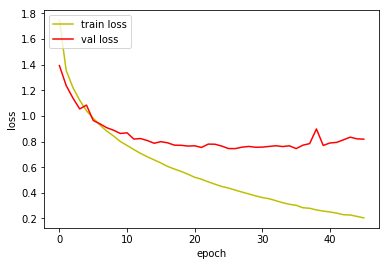

In [8]:
fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()   